# Embeddings de Alpha Earth a nodos de OSM

El objetivo de este notebook es colapsar los embeddings de alpha earth extraídos en ```AE_embeddings_extraction.ipynb``` a los nodos de Open Street Map. Para esto, se toman todos los embeddings en un radio de *MAX DISTANCE* de cada nodo, y se toma promedio. Ese será el vector de embeddings Alpha Earth asociado a ese nodo.

La metodología es la siguiente: se hace un join entre los DataFrames de puntos de OSM **(poi)** y el dataset de comunas de santiago **(comunas)**. De esta manera, asociamos cada punto de interés a una comuna. Luego 

### imports, lecturas y alineamiento de crs

In [9]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx

import matplotlib.pyplot as plt
import re

from utils import networkx_graph_to_gdf, try_int

In [10]:
ae_emb = gpd.read_file("../data/embeddings_alpha_earth.gpkg")
ae_emb = gpd.GeoDataFrame(ae_emb, geometry=gpd.points_from_xy(ae_emb.lon, ae_emb.lat), crs="EPSG:4326")

poi_graph = nx.read_gexf("../data/grafo_OSM/grafo_santiago_filtrado.gexf")
poi = networkx_graph_to_gdf(poi_graph)

if ae_emb.crs != poi.crs:
    poi = poi.to_crs(ae_emb.crs)

Text(0.5, 0.98, 'Distribución espacial de muestras AlphaEarth y Puntos de Interés OSM en Santiago')

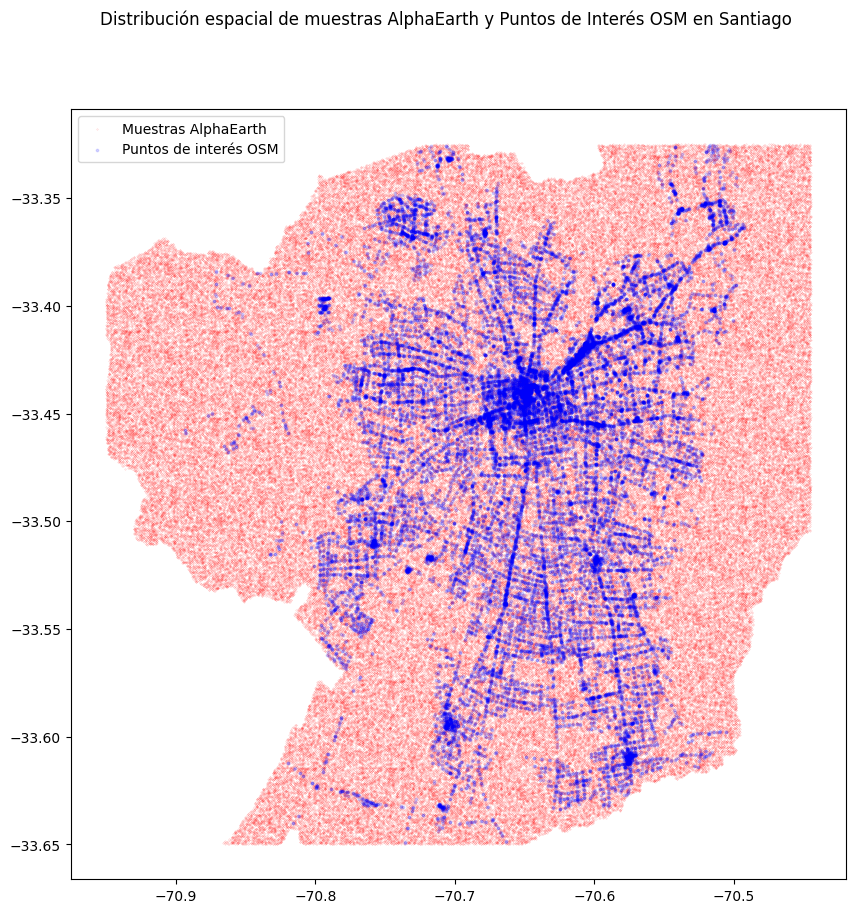

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(ae_emb.geometry.x, ae_emb.geometry.y, s=.05, alpha=0.3, color="red", label="Muestras AlphaEarth")
ax.scatter(poi.geometry.x, poi.geometry.y, s=3, alpha=0.15, color="blue", label="Puntos de interés OSM")
plt.legend()
plt.suptitle("Distribución espacial de muestras AlphaEarth y Puntos de Interés OSM en Santiago")

### Asignación de embeddings a cada nodo del grafo

In [12]:
MAX_DISTANCE = 200  # Radio de búsqueda en metros para los embeddings
CRS_METRICO = 32719  # UTM zona 19S para Santiago

poi_m = poi.to_crs(epsg=CRS_METRICO)
ae_m = (
    ae_emb.to_crs(epsg=CRS_METRICO)
          .reset_index()
          .rename(columns={"index": "ae_index"})
)

In [13]:
poi_buffer = poi_m.copy()
poi_buffer["geometry"] = poi_buffer.geometry.buffer(MAX_DISTANCE)

matches = gpd.sjoin(
    ae_m,                                # <-- EN CRS METRICO
    poi_buffer[["node_id", "geometry"]], # <-- EN CRS METRICO
    how="inner",
    predicate="within",
)

In [14]:
poi_to_embeddings = (
    matches.groupby("node_id")["ae_index"]
           .agg(list)
           .reset_index(name="ae_indices")
)

poi_enriched = poi.merge(poi_to_embeddings, on="node_id", how="left")

In [15]:
sin_embeddings = poi_enriched[
    poi_enriched["ae_indices"].isna() |
    poi_enriched["ae_indices"].apply(lambda x: len(x) == 0 if isinstance(x, list) else False)
]

n_sin_embeddings = len(sin_embeddings)
n_total = len(poi_enriched)

print(f"Nodos sin embeddings asignados: {n_sin_embeddings} de {n_total} ({n_sin_embeddings/n_total:.1%})")
sin_embeddings.head()

Nodos sin embeddings asignados: 0 de 29267 (0.0%)


,node_id,lat,lon,tipo,nombre,geometry,ae_indices


### Visualización de clusters generados

In [21]:
import matplotlib.pyplot as plt

# Asegurar CRS métrico
gdf_poi = poi_enriched.to_crs(epsg=32719)

# Crear cluster_id como string (1 por nodo)
gdf_poi["cluster_id"] = gdf_poi["node_id"].astype(str)

# Lista de clusters
unique_clusters = gdf_poi["cluster_id"].unique()
n_clusters = len(unique_clusters)

# Elegir colormap
cmap = plt.cm.get_cmap("tab20", n_clusters) if n_clusters <= 20 else plt.cm.get_cmap("hsv", n_clusters)

# Asignar color a cada cluster
cluster_to_color = {clust: cmap(i) for i, clust in enumerate(unique_clusters)}
gdf_poi["color"] = gdf_poi["cluster_id"].map(cluster_to_color)


/var/folders/w5/kmvyzkpj2q1fyf7tnn3nqwb40000gn/T/ipykernel_75233/3940694204.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", n_clusters) if n_clusters <= 20 else plt.cm.get_cmap("hsv", n_clusters)


### Conteo de embeddings por nodo

count    29267.000000
mean        23.922267
std          5.133921
min          8.000000
25%         20.000000
50%         24.000000
75%         27.000000
max         50.000000
Name: n_embeddings, dtype: float64


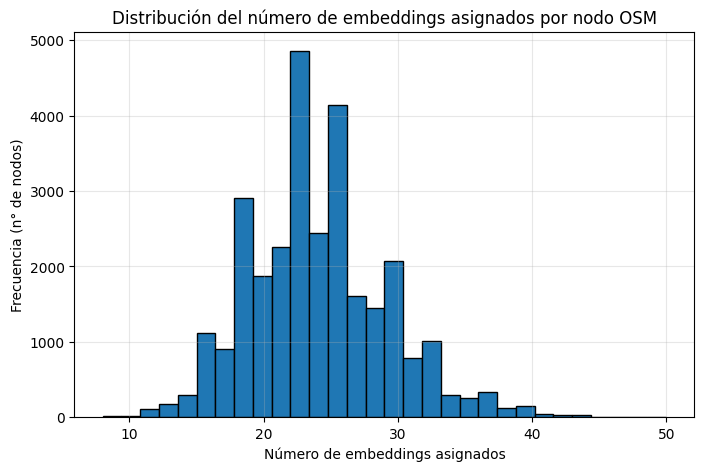

In [20]:
emb_count = matches.groupby("node_id").size().reset_index(name="n_embeddings")
print(emb_count["n_embeddings"].describe())

plt.figure(figsize=(8,5))
plt.hist(emb_count["n_embeddings"], bins=30, edgecolor="black")
plt.title("Distribución del número de embeddings asignados por nodo OSM")
plt.xlabel("Número de embeddings asignados")
plt.ylabel("Frecuencia (n° de nodos)")
plt.grid(alpha=0.3)
plt.show()


### Conversión de Alpha Earth Embeddings a nodos

Se toma promedio de los embeddings asociados a cada nodo.

In [23]:
# columnas A00–A63
embedding_cols = [col for col in matches.columns if re.match(r"^A\d+$", col)]

# promedio por nodo
poi_emb_mean = (
    matches.groupby("node_id")[embedding_cols]
    .mean()
    .reset_index()
)

In [24]:
poi_meta = poi[
    ["node_id", "nombre", "tipo", "lat", "lon", "geometry"]
].drop_duplicates(subset="node_id")

poi_emb_enriched = poi_emb_mean.merge(
    poi_meta, 
    on="node_id",
    how="inner"
)

In [25]:
poi_emb_enriched_gdf = gpd.GeoDataFrame(
    poi_emb_enriched,
    geometry="geometry",
    crs=poi.crs
)

# Convertimos id de nodos a int si vienen como string
mapping = {n: try_int(n) for n in list(poi_graph.nodes)}
if any(k != v for k, v in mapping.items()):
    poi_graph = nx.relabel_nodes(poi_graph, mapping, copy=True)

poi_nodes = poi_emb_enriched_gdf.copy()
poi_nodes["node_id_norm"] = poi_nodes["node_id"].apply(try_int)

embedding_cols = [c for c in poi_nodes.columns if re.fullmatch(r"A\d+", c)]

### Construcción de grafo final

In [26]:
def row_to_attrs(row):
    attrs = {
        "nombre": row.get("nombre"),
        "tipo": row.get("tipo"),
        "lat": float(row["lat"]) if pd.notnull(row.get("lat")) else None,
        "lon": float(row["lon"]) if pd.notnull(row.get("lon")) else None,
    }
    for c in embedding_cols:
        val = row[c]
        if pd.notnull(val):
            attrs[c] = float(val)
    return attrs

attrs_dict = {
    row["node_id_norm"]: row_to_attrs(row)
    for _, row in poi_nodes.iterrows()
}

missing_in_graph = []
for nid, attrs in attrs_dict.items():
    if nid in poi_graph:
        poi_graph.nodes[nid].update(
            {k: v for k, v in attrs.items() if v is not None}
        )
    else:
        missing_in_graph.append(nid)

print("Nodos con embeddings que NO están en el grafo:", len(missing_in_graph))

Nodos con embeddings que NO están en el grafo: 0


In [27]:
nx.write_gexf(
    poi_graph, 
    "../data/grafo_santiago_filtrado_con_embeddings.gexf"
)

print("GEXF enriquecido guardado correctamente.")

GEXF enriquecido guardado correctamente.
